In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False,
                       model_top=None,
                       model_medium=None,
                       model_bottom=None, 
                       reverse=False, 
                       legend_labels=None):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    if legend_labels is None:
        labels = [None for i in range(len(colors))]
        zipper = zip(colors, xvals, yvals, labels)
    else:
        zipper = zip(colors, xvals, yvals, legend_labels)

    for color, x, Y, label in zipper:
        
        if reverse:
            Y = -Y
        bot, mid, top = [_.ravel() for _ in
                         np.percentile(Y, [25, 50, 75], axis=0)]
        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color, label=label)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    if model_top is not None:
        if use_fill_between:
            ax.fill_between(x, model_bottom.flat, model_top.flat, color=color, alpha=0.15)
        for x in xvals:
            ax.plot(x, model_top, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_bottom, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_medium, color=[158, 218, 229])

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

    # set the alignment for outer ticklabels
    ax.set_xticks([0, 25, 50, 75, 100])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")
    ax.legend()
    
    
model_list = [
    'BO',
    'BO_noise',
    'LinearBO',
    'LinearBO_noise',
    'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]


tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(model_list)]  # color bar

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

def save_result_image(result_daraframes, result_daraframes_1, save_name):
    x_vals = []
    lengths = [result_dataframe.shape[1] for result_dataframe in result_daraframes]
    for i in range(len(result_daraframes)):
        x = np.arange(0, min(lengths), 1)
        x_vals.append(x)
        result_daraframes[i] = result_daraframes[i].iloc[:, :min(lengths)]
        
    fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
    results_plot_maker(a[0], result_daraframes, x_vals, 'Iteration', save_name, 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
    results_plot_maker(a[1], result_daraframes_1, x_vals, 'Iteration', 'Simple regret', 'Simple regret', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, legend_labels=model_list)
    # plt.legend()
    plt.savefig(save_name+'.pdf', format='pdf')

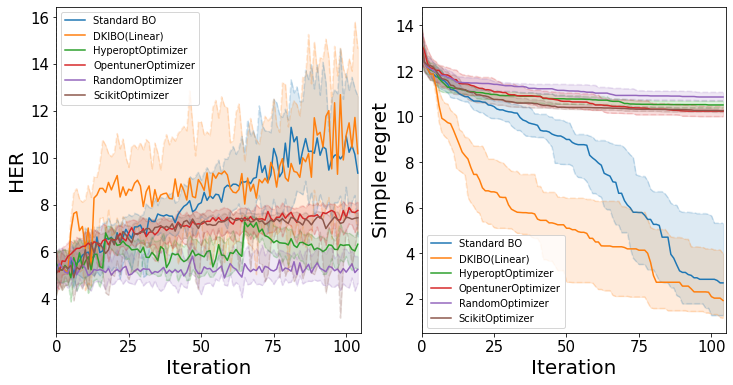

In [3]:

problem_name = 'photocatalysis_experiment'

base_path = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results'

model_list = [
    'standardBO',
    'LinearBO',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

result_dfs = []
for i in model_list:
    result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(i, problem_name)), index_col=0))

model_list = [
    'SBO',
    'DKIBO(Linear)',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]
        
def show_pic(result_dfs):
    
    def transform_to_regret(dfs):
        maximum = 0
        for df in dfs:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in dfs:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs
    result_daraframes_regret = transform_to_regret(result_dfs)
    save_result_image(result_dfs, result_daraframes_regret, 'HER')
    
show_pic(result_dfs)

In [4]:
import os


model_list = [
    'standardBO',
    'RFBO',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

test_problems = [
    'Colville',
    'Michalewicz10',
    'Ackley',
    'Branin',
    'Eggholder',
    'GoldsteinPrice',
    'SixHumpCamel',
    'Hartmann6',
    'Rosenbrock',
    'StyblinskiTang',
]

base_dir = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results'

def read_data(model_list, test_problems):
    dfs = {}
    for problem_name in test_problems:
        df_list = []
        for model_name in model_list:
            df_list.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(model_name, problem_name)), index_col=0))

        dfs[problem_name] = df_list
    return dfs


dfs = read_data(model_list, test_problems)


def get_result_dicts(result_dfs, model_list):
    
    result_dicts = []
    def transform_to_regret(df_s):
        maximum = -10000
        for df in df_s:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in df_s:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs, maximum
    
    def get_regret(df):
        regret_list = []
        # mean regret
        for i in range(len(df)):
            trial_minimum = df.iloc[i, -1]
            regret_list.append(trial_minimum)
        regret_list = np.array(regret_list)
        return regret_list
    
    result_regret_dfs, max_value = transform_to_regret(result_dfs)
    
    for i, result_df in enumerate(result_dfs):
        result_dict = {'name': model_list[i]}
    
        df_mean = result_df.T.mean().to_numpy()
        result_dict['mean_value_deviation'] = np.mean(np.abs(df_mean-np.mean(df_mean)))
        result_regret_df = result_regret_dfs[i]
        result_regre = get_regret(result_regret_df)
        
        result_dict['CMR'] = np.percentile(result_regret_df.mean(axis=1), 50)
        result_dict['CMR_deviation'] = np.sqrt(np.mean((result_regre - result_dict['CMR'])**2))
        result_dict['median_regret'] = np.percentile(result_regre, 50)
        result_dict['median_regret_deviation'] =np.sqrt(np.mean((result_regre - result_dict['median_regret'])**2))
        result_dicts.append(result_dict)
        # break
    return result_dicts

    
def show_result(dfs, problems, output_file=False, output_file_name='df_result.xlsx'):
    
    writer = pd.ExcelWriter(output_file_name)
    for problem in problems:
        result_dfs = dfs[problem]
        result = get_result_dicts(result_dfs, model_list)
        print(result)

        result_df = pd.DataFrame([], columns=['name', 'CMR', 'CMR_deviation', 'median_regret', 'median_regret_deviation'])
        for result_line in result:
            result_df = result_df.append(result_line, ignore_index=True)

        if output_file:
            result_df.to_excel(writer, sheet_name=problem)
    
    if output_file:
        writer.save()
    
    
show_result(dfs, test_problems, output_file=True, output_file_name='synthetic_analysis.xlsx')

[{'name': 'standardBO', 'mean_value_deviation': 12075.163807423134, 'CMR': 3003.7648659539595, 'CMR_deviation': 2964.779697803468, 'median_regret': 39.522052846538145, 'median_regret_deviation': 22.552082440893102}, {'name': 'RFBO', 'mean_value_deviation': 6152.165596044175, 'CMR': 2851.9505829678455, 'CMR_deviation': 2753.5017188613338, 'median_regret': 31.614104469475393, 'median_regret_deviation': 209.87363595491985}, {'name': 'HyperoptOptimizer', 'mean_value_deviation': 4404.287315905134, 'CMR': 2908.3858417155934, 'CMR_deviation': 2447.8933965870233, 'median_regret': 383.28847965997244, 'median_regret_deviation': 353.2008541250837}, {'name': 'OpentunerOptimizer', 'mean_value_deviation': 23048.05138829035, 'CMR': 2466.440340480872, 'CMR_deviation': 2227.983639602677, 'median_regret': 157.90805222321578, 'median_regret_deviation': 269.58989685728733}, {'name': 'RandomOptimizer', 'mean_value_deviation': 20964.707595990156, 'CMR': 3134.1428277948808, 'CMR_deviation': 2224.163488976995

[{'name': 'standardBO', 'mean_value_deviation': 0.1369705515761725, 'CMR': 0.7132529293264827, 'CMR_deviation': 0.6823195635264225, 'median_regret': 0.0016701882264900103, 'median_regret_deviation': 0.06179039285960951}, {'name': 'RFBO', 'mean_value_deviation': 0.1970296312157988, 'CMR': 0.7002918776100246, 'CMR_deviation': 0.6289279870384364, 'median_regret': 0.012300870316435342, 'median_regret_deviation': 0.23967250766616086}, {'name': 'HyperoptOptimizer', 'mean_value_deviation': 0.0719764513192912, 'CMR': 1.4087394108273759, 'CMR_deviation': 0.6853333023391055, 'median_regret': 0.7706886855016863, 'median_regret_deviation': 0.2758923673379017}, {'name': 'OpentunerOptimizer', 'mean_value_deviation': 0.2706928109422347, 'CMR': 0.8567215081216788, 'CMR_deviation': 0.6986520517509364, 'median_regret': 0.14582130245227742, 'median_regret_deviation': 0.12639147815202414}, {'name': 'RandomOptimizer', 'mean_value_deviation': 0.03257807818678322, 'CMR': 1.7257441675114304, 'CMR_deviation': 

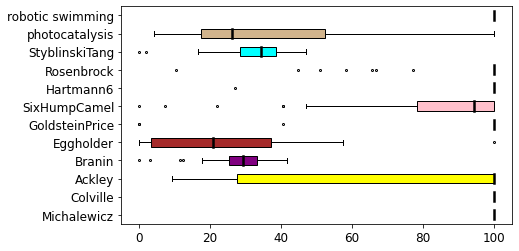

In [28]:
# get the proportion of iterations using predictive model
# 看Predictive model占比
# todo：现在这个代码不对，需要加入50iteration的支持和计算标准差

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_dir = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_result_early_drop_proportion'

test_problems = [
    'Michalewicz10',
    'Colville',
    'Ackley',
    'Branin',
    'Eggholder',
    'GoldsteinPrice',
    'SixHumpCamel',
    'Hartmann6',
    'Rosenbrock',
    'StyblinskiTang',
    'photocatalysis',
    'swimmer'
]

color_bar = [
    'blue',
    'red',
    'yellow',
    'purple',
    'brown',
    'orange',
    'pink',
    'lightgreen',
    'cyan',
    'aqua',
    'tan',
    'olive',
]

# get predictive model proportion result of one dataframe
def get_result(result_df):
    array = np.array(result_df['Predictive model'])
    array = np.array([eval(i) for i in array])
    array = array.squeeze()
    zero_count = 0
    for i in array:
        if i == 0:
            zero_count += 1
    return 1 - zero_count/len(array)

def plot_all_proportion(base_dir):
    file_names = [i for i in os.listdir(base_dir) if 'proportion' in i]
    dfs = {}
    dfs_noise = {}
    for test_problem in test_problems:
        dfs[test_problem] = []
        dfs_noise[test_problem] = []
    for test_problem in test_problems:
        for file in file_names:
            if test_problem + '_' in file:
                dfs_noise[test_problem].append(get_result(pd.read_csv(os.path.join(base_dir, file), index_col=0)))
    
    proportion_list = [1.0]
    std_list = []
    box_plot = []
    name_list = []
    for key in dfs_noise.keys():
        if key == 'swimmer':
            name_list.append('robotic swimming')
        elif key == 'Michalewicz10':
            name_list.append('Michalewicz')
        else:
            name_list.append(key)
        proportion_list.append(np.mean(dfs_noise[key]))
        std_list.append(np.std(dfs_noise[key]))
        l = [i * 100 for i in dfs_noise[key]]
        box_plot.append(l)
    
    plt.figure(figsize=(7, 4))
    boxplot_fig = plt.boxplot(box_plot, labels=name_list, vert=False, patch_artist=True, medianprops=dict(linewidth=2.5, color='black'), 
                             flierprops=dict(markersize=2))
    
    for i, box in enumerate(boxplot_fig['boxes']):
        box.set(facecolor=color_bar[i])
    plt.tick_params(labelsize=12)
    plt.savefig("predictive_model_proportion.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return box_plot
    
box_plot = plot_all_proportion(base_dir)

In [44]:
#  generate results for kappa comparison

path = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\result_collection'

df_bo_5 = pd.read_csv(os.path.join(path, 'BO_result_test_photocatalysis_experiment.csv'), index_col=0)
df_bo_2 = pd.read_csv(os.path.join(path, 'standardBO_result_test_photocatalysis_experiment.csv'), index_col=0)
df_bo_1 = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_8_23_14_33_ucb_1.288\BO_result_test_photocatalysis_experiment.csv', index_col=0)
df_rf = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_8_23_13_18_regression_only_2.576\BO_result_test_photocatalysis_experiment.csv', index_col=0)
df_linear = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_9_1_14_54_ucb_without_mean_2.576_Linear\BO_result_test_photocatalysis_experiment.csv', index_col=0)

problems = ['photocatalysis']
dfs['photocatalysis'] = [df_bo_5, df_bo_2, df_bo_1, df_rf, df_linear]
show_result(dfs, problems, output_file=True, output_file_name='photocatalysis_change_parameter.xlsx')

[{'name': 'BO', 'mean_value_deviation': 0.4725426024827503, 'CMR': 9.382378110431489, 'CMR_deviation': 4.352563024001828, 'median_regret': 6.209278583526611, 'median_regret_deviation': 2.6826877877803286}, {'name': 'BO_noise', 'mean_value_deviation': 0.5754636783345538, 'CMR': 5.521421595982143, 'CMR_deviation': 3.4044487801117786, 'median_regret': 2.216951370239258, 'median_regret_deviation': 1.6938242497095868}, {'name': 'LinearBO', 'mean_value_deviation': 0.8258326151784263, 'CMR': 7.788989623387654, 'CMR_deviation': 5.255148593130032, 'median_regret': 2.391535758972168, 'median_regret_deviation': 2.4237543205803034}, {'name': 'LinearBO_noise', 'mean_value_deviation': 0.1539341346668063, 'CMR': 10.738526312510173, 'CMR_deviation': 0.34950900371064336, 'median_regret': 10.454555034637451, 'median_regret_deviation': 0.1421335250032175}, {'name': 'LinearBOEarlyStop', 'mean_value_deviation': 0.8381359027435665, 'CMR': 6.53079530398051, 'CMR_deviation': 2.6189486030694034, 'median_regret

# Extra experiment: RF-DKIBO

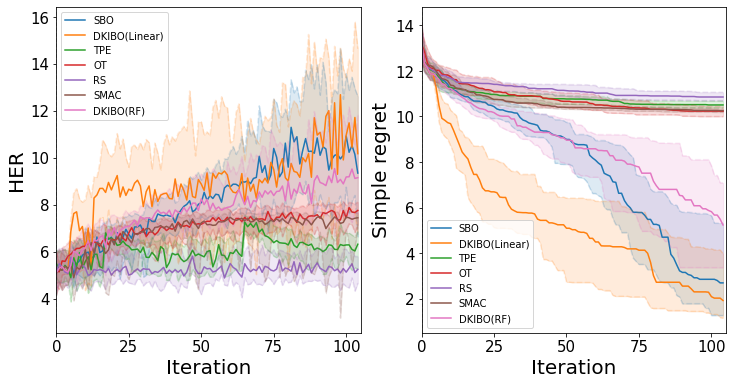

In [2]:

problem_name = 'photocatalysis_experiment'

base_path = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results'

model_list = [
    'standardBO',
    'LinearBO',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

result_dfs = []
for i in model_list:
    result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(i, problem_name)), index_col=0))
    
result_dfs.append(pd.read_csv(r'C:\experiment_results\2023_6_30_11_33_ucb_2.576\RFBO_result_test_photocatalysis_experiment.csv', index_col=0))

model_list = [
    'SBO',
    'DKIBO(Linear)',
    'TPE',
    'OT',
    'RS',
    'SMAC',
    'DKIBO(RF)'
]
        
def show_pic(result_dfs):
    
    def transform_to_regret(dfs):
        maximum = 0
        for df in dfs:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in dfs:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs
    result_daraframes_regret = transform_to_regret(result_dfs)
    save_result_image(result_dfs, result_daraframes_regret, 'HER')
    
show_pic(result_dfs)